# DDPM Editing Experiment

This experiment aims at exploring the DDPM model's ability to edit images similar to the paper [SDEdit](https://github.com/ermongroup/SDEdit). 

There are two edit mode we are exploring in this notebook.
- **Global Editing**, where we edit the entire image.
- **Partial Editing**, where we edit a part of the image based on a mask. 

For both modes, we will test how the number of forward diffusion steps affects the quality (and diversity) of the generated image. 

For partial editing, we will additionally test the effect of the mask size on the quality (and diversity) of the generated image. 

In [ ]:
import matplotlib.pyplot as plt
from models.viz_utils import save_sampling_video, visualize_elevation_map
from data_script.elevation_dataset import ElevationDataset
from models.ddpm_edit import Editor
import torch
from models.util import ScaleToRange, scale_to_range
import numpy as np
%load_ext autoreload
%autoreload 2

/home/sp/anaconda3/envs/diffusion/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# original dataset, the output is scaled to [-1, 1]
dataset = ElevationDataset('/home/sp/Downloads/elevation')
# we use the same editor for both global and partial editing
editor = Editor("/home/sp/terrain/denoising-diffusion-pytorch/results/model-3.pt")

## 1. Global Editing

In [ ]:
# randomly choose one terrain image to edit from the dataset
random_index = np.random.randint(0, len(dataset))
original_data_sample, _ = dataset[random_index]
original_data_sample = original_data_sample.to("cuda")
print(original_data_sample.shape)

torch.Size([1, 128, 128])


In [ ]:
# choose 6 different forward steps 
ts = torch.tensor([50, 100, 200, 400, 800, 1000], device=torch.device("cuda"))
# every diffusion step is used to generate 5 samples to test the diversity 
num_samples = 5 

## 2.1 Generate Edited Samples

In [ ]:
repeated_original_data_sample = original_data_sample.unsqueeze(dim=0).repeat(num_samples, 1, 1, 1)
# we add noises to the denoised sample
edited_samples = []
for i in range(ts.shape[0]):
    edited_x, all_edited_x = editor(repeated_original_data_sample, ts[i:i+1].item(), keep_intermediate=True)
    edited_samples.append(all_edited_x)
    print("Shape", all_edited_x.shape)

sampling loop time step: 100%|██████████| 50/50 [00:02<00:00, 21.65it/s]


Shape torch.Size([5, 51, 1, 128, 128])


sampling loop time step: 100%|██████████| 100/100 [00:02<00:00, 45.19it/s]


Shape torch.Size([5, 101, 1, 128, 128])


sampling loop time step: 100%|██████████| 200/200 [00:04<00:00, 44.68it/s]


Shape torch.Size([5, 201, 1, 128, 128])


sampling loop time step: 100%|██████████| 400/400 [00:09<00:00, 44.36it/s]


Shape torch.Size([5, 401, 1, 128, 128])


sampling loop time step: 100%|██████████| 800/800 [00:18<00:00, 43.99it/s]


Shape torch.Size([5, 801, 1, 128, 128])


sampling loop time step: 100%|██████████| 1000/1000 [00:22<00:00, 43.79it/s]

Shape torch.Size([5, 1001, 1, 128, 128])


## 2.2 Visualize Edited Samples

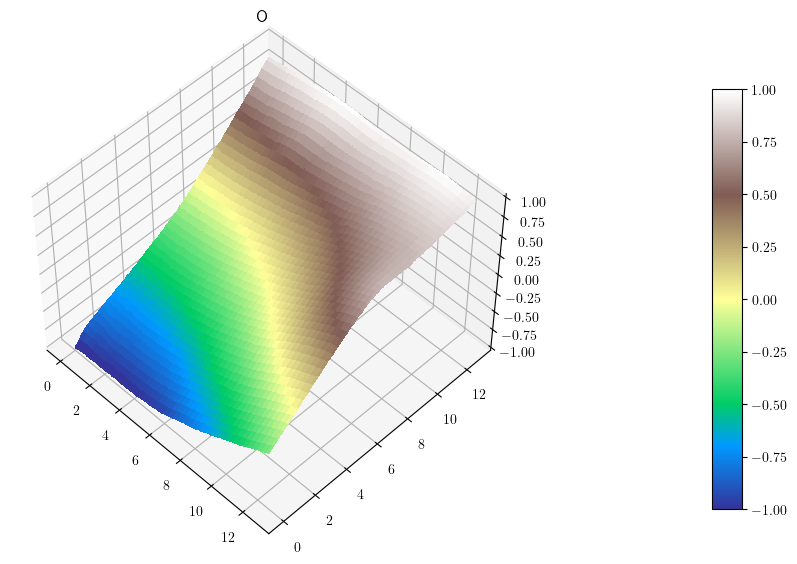

In [ ]:
visualize_elevation_map(original_data_sample, 1, 1, subtitles="Original", save_dir="test_imgs/original.png")

In [ ]:
# visualize videos
# for i in [0, 4]:
    # we only visualize the first and last samples 
    # for j in [0, 4]:
        # save_sampling_video(edited_samples[i][j], f"media/global_editing/step_{ts[i].item()}_{j}.mp4", ts[i].item()+1)

In [ ]:
# visualize images 
final_edited_samples = []
for i in range(ts.shape[0]):
    # each sample is of shape (B, C, H, W) 
    final_edited_samples.append(edited_samples[i][:, -1])
# (T, B, C, H, W)
final_edited_samples = torch.stack(final_edited_samples, dim=0)
# final_edited_samples = final_edited_samples.view(-1, 128, 128)

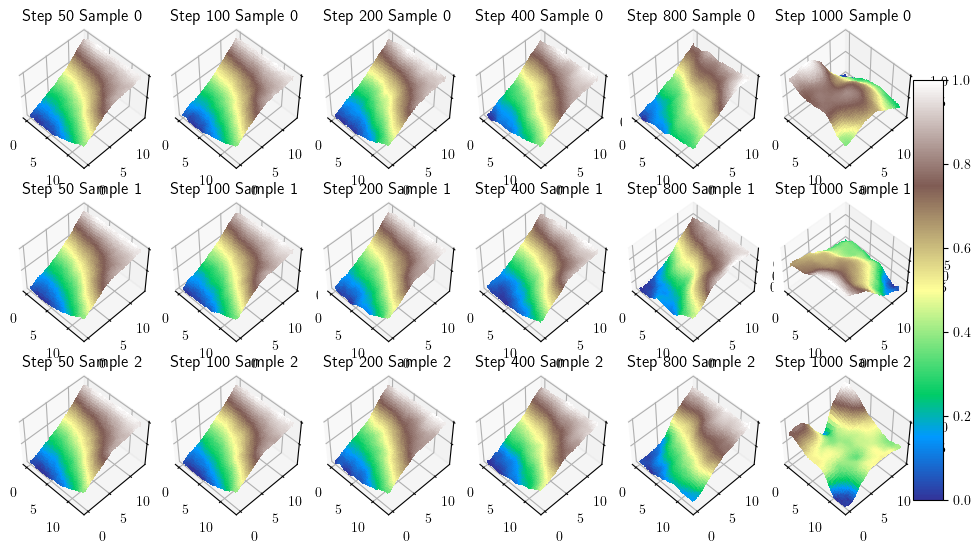

In [ ]:
subtitles = [f"Step {ts[j].item()} Sample {i}" for i in range(3) for j in range(ts.shape[0])]
visualize_elevation_map(final_edited_samples[:, :3].transpose(1, 0).reshape(-1, 128, 128), 3, 6, subtitles=subtitles, save_dir="test_imgs/edited.png")

In [ ]:
def compute_var(x):
    return torch.var(x, dim=(0)).sum().item()

variance = [compute_var(final_edited_samples[i]) for i in range(ts.shape[0])]
print(variance)

In [ ]:
fig, axis = plt.subplots()
fig.set_size_inches(5, 3)
axis.plot(ts.cpu().detach().numpy(), variance, marker='o')
axis.set_xlabel("Forward Steps")
axis.set_ylabel("Variance")
fig.savefig("test_imgs/ddpm-editing-variance.png", dpi=300, bbox_inches='tight')
plt.show()